# Evaluación Modular 6: Segmentación y Detección de Anomalías en Pacientes Crónicos

Objetivo:
Aplicar técnicas avanzadas de aprendizaje no supervisado para identificar grupos de pacientes
con condiciones clínicas similares, visualizar dichos segmentos en espacios de baja dimensión,
detectar perfiles atípicos y analizar comparativamente distintos métodos de agrupamiento. Los
estudiantes implementarán modelos de clustering como K-Means, DBSCAN o jerárquicos,
emplearán técnicas de reducción de dimensionalidad como PCA o t-SNE para representar los
resultados, y justificarán sus decisiones en función del contexto clínico y los resultados
obtenidos.

###Descripción breve de las variables y su relación con la predicción de diabetes:
- Pregnancies: Número de veces que la paciente ha estado embarazada. Un alto número puede estar asociado con un mayor riesgo.
- Glucose: Concentración de glucosa en plasma. Un nivel elevado es el indicador más directo de diabetes.
- BloodPressure: Presión arterial diastólica. La hipertensión es un factor de riesgo.
- SkinThickness: Grosor del pliegue cutáneo del tríceps. Refleja la adiposidad, un factor de riesgo de resistencia a la insulina.
- Insulin: Nivel de insulina sérica. Anomalías pueden indicar disfunción pancreática.
- BMI: Índice de masa corporal. La obesidad es un factor de riesgo importante para la diabetes tipo 2.
- DiabetesPedigreeFunction: Función que puntúa la predisposición genética a la diabetes basándose en el historial familiar.
- Age: Edad. El riesgo de diabetes generalmente aumenta con la edad.
- Outcome: Variable objetivo (0 para no diabético, 1 para diabético)

## Cargar Librerias

In [ ]:
# Cargar librerias necesarias
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import DBSCAN, HDBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import numpy as np

from sklearn.neighbors import NearestNeighbors







## 1. Preprocesamiento y reducción de dimensionalidad

In [ ]:
# Carga y exploración de datos
print("---Carga  y exploración de datos ---")

# Descargar el dataset "Pima Indians Diabetes Dataset". Fuente: Kaggle, via Plotly

try:
    df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv')
    print("Dataset cargado exitosamente desde la URL.")
except Exception as e:
    print(f"Error al cargar el dataset desde la URL: {e}")
    print("Intentando cargar 'diabetes.csv' desde el entorno local de Colab. Asegúrate de haberlo subido.")
    df = pd.read_csv('diabetes.csv')
    print("Dataset cargado exitosamente desde el archivo local.")

print("Dimensiones del dataset:", df.shape)

print("\nPrimeras 5 filas del dataset:")
print(df.head())

print("\nInformación del dataset:")
df.info()

print("\nEstadísticas descriptivas del dataset:")
print(df.describe())

# Reemplazar valores cero por NaN en columnas donde no son físicamente posibles
# Columnas: Glucose, BloodPressure, SkinThickness, Insulin, BMI
cols_to_check = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_to_check] = df[cols_to_check].replace(0, np.nan)

print("\nConteo de valores nulos después de reemplazar 0s (antes de imputación):")
print(df.isnull().sum())

---Carga  y exploración de datos ---
Dataset cargado exitosamente desde la URL.
Dimensiones del dataset: (768, 9)

Primeras 5 filas del dataset:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                 

##  Preprocesamiento e Imputacion de valores Nans.

In [ ]:
# Preprocesamiento
print("\n--- Preprocesamiento ---")

# Imputar valores nulos (NaNs) con la median de sus respectivas columnas
for col in cols_to_check:
    df[col].fillna(df[col].median(), inplace=True)

print("\nConteo de valores nulos después de la imputación (debería ser 0):")
print(df.isnull().sum())



--- Preprocesamiento ---

Conteo de valores nulos después de la imputación (debería ser 0):
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


/tmp/ipython-input-4202450279.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


## Visualización ScatterPlot SPLOM

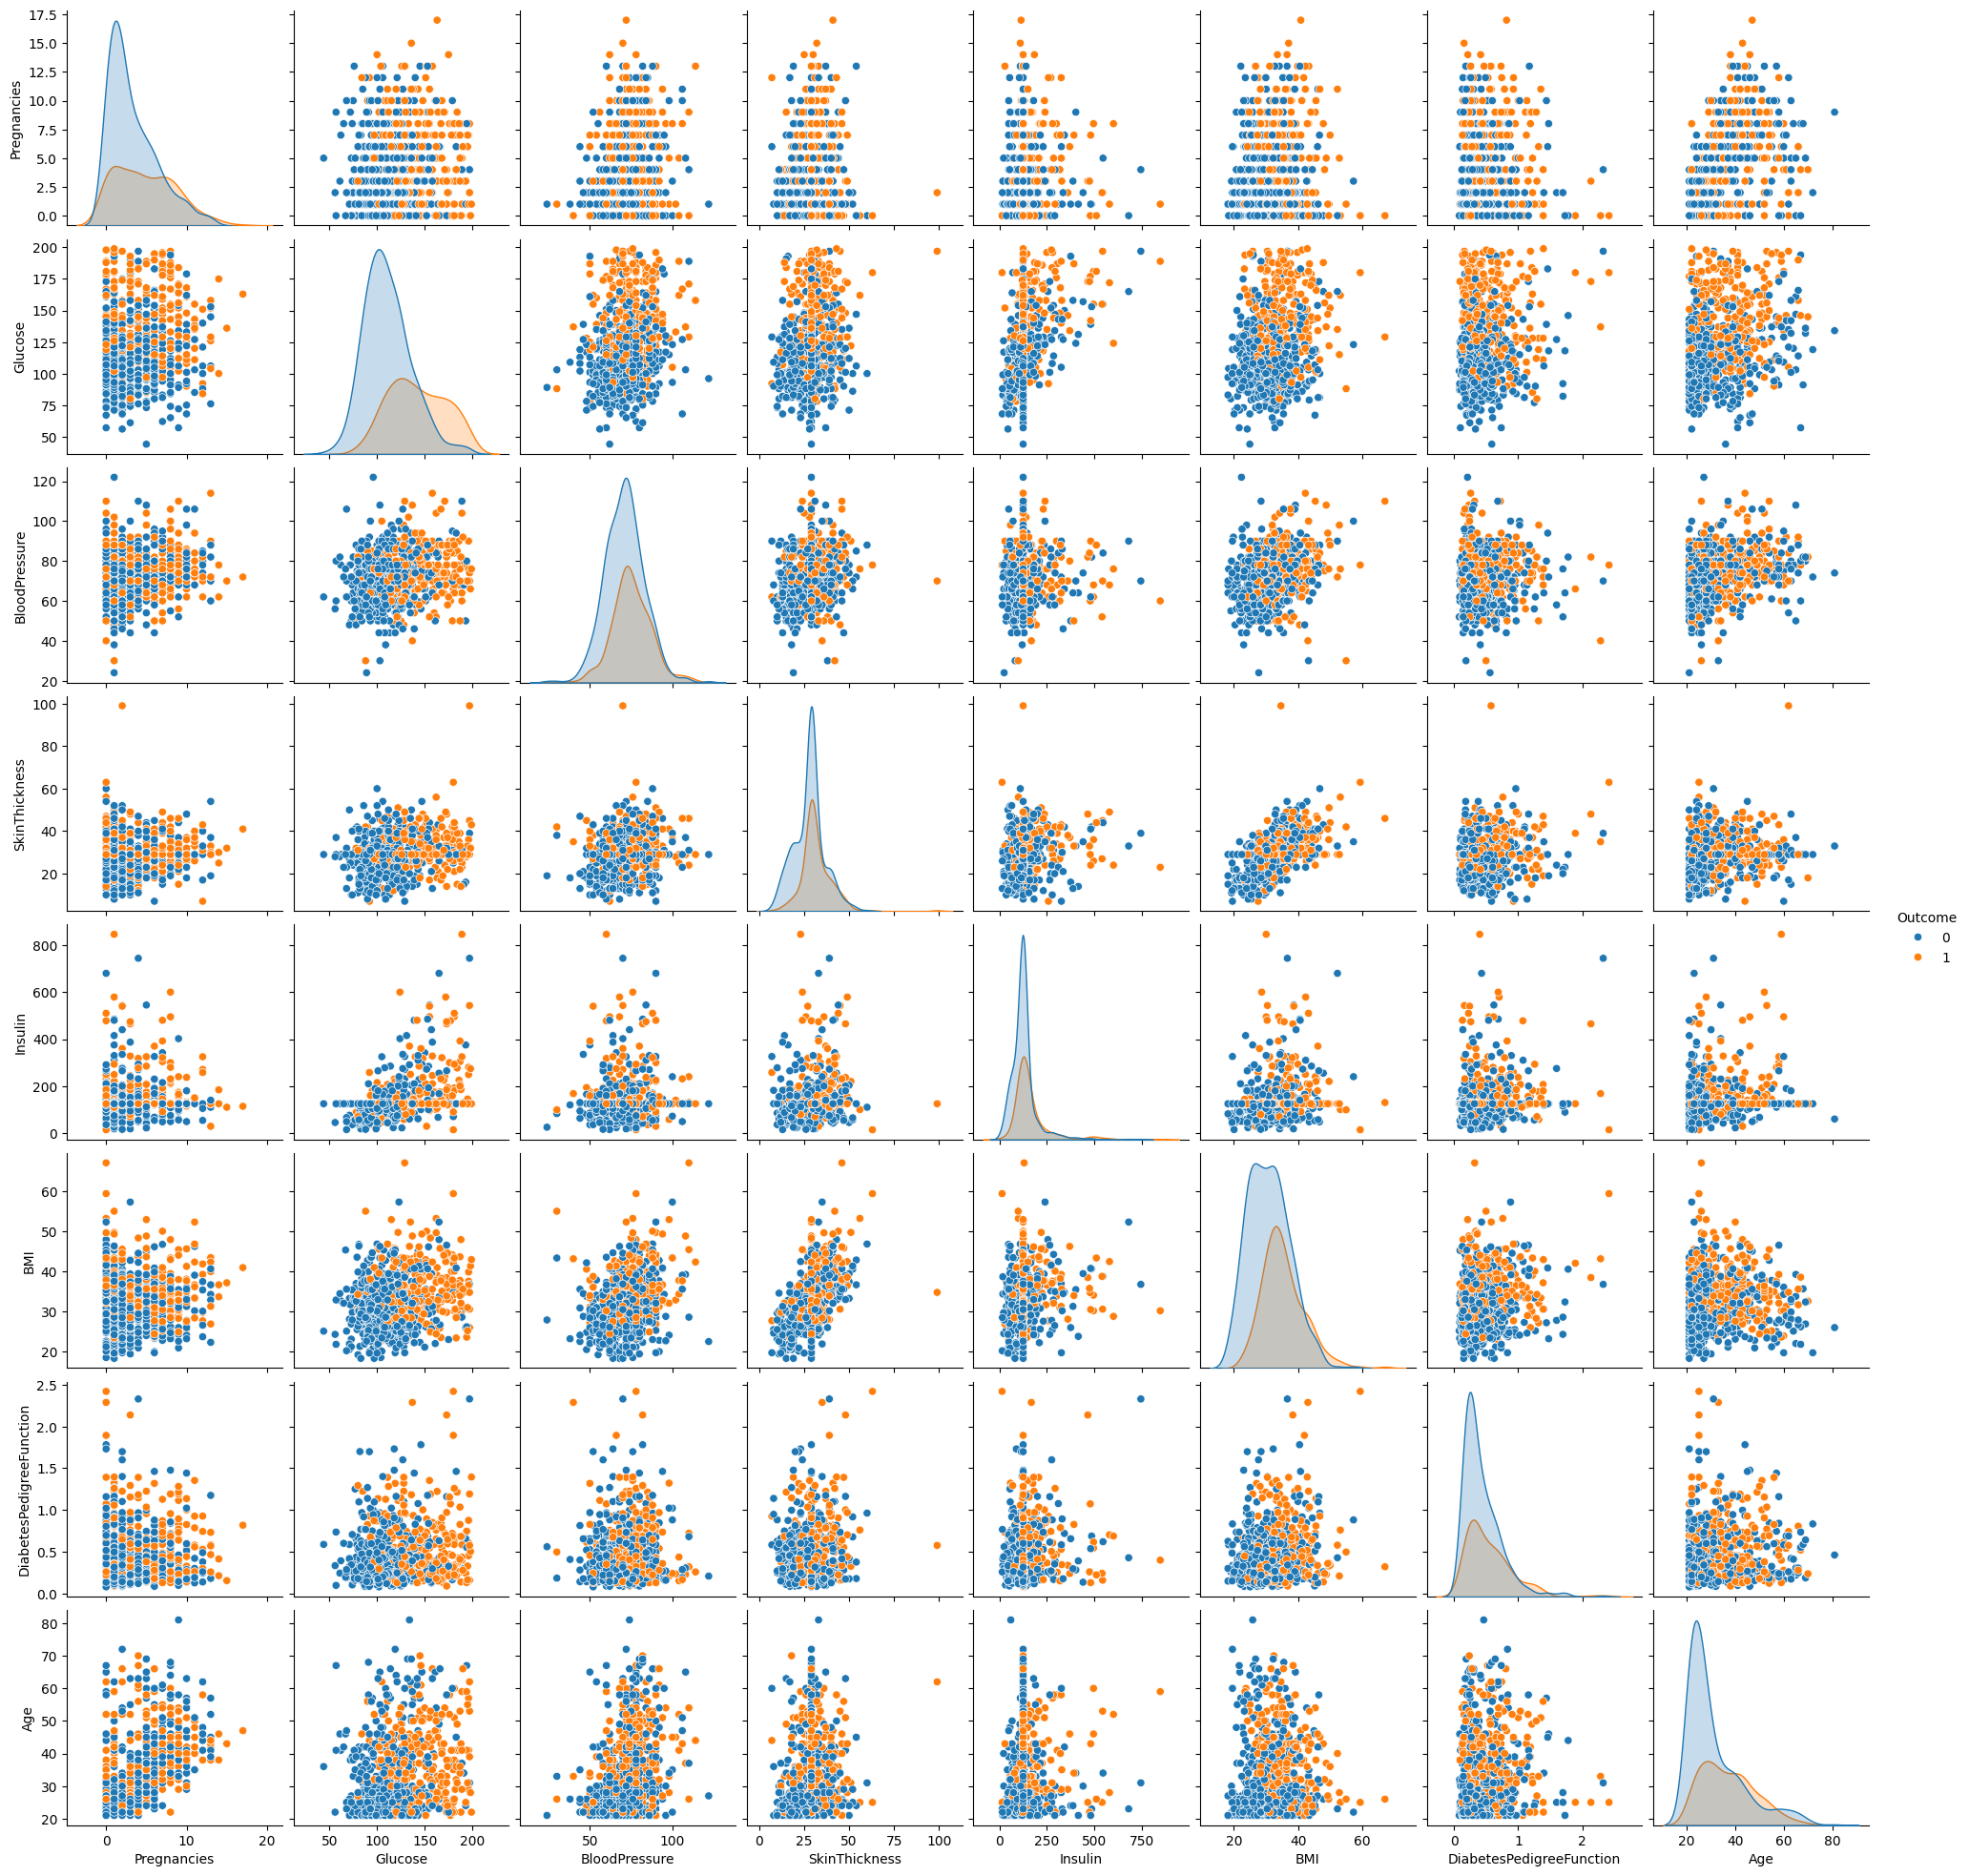

In [ ]:
# scatterplot matrix SPLOM
sns.pairplot(df, hue='Outcome')

## Separar características y Estandarizar.

In [ ]:
# Separamos características (X) y el objetivo (y) aunque 'y' no se usará para el clustering
X = df.drop('Outcome', axis=1)
y = df['Outcome'] # Se usará solo para colorear las visualizaciones y validar

# Estandarizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Dimensiones de los datos escalados:", X_scaled.shape)

Dimensiones de los datos escalados: (768, 8)


## Aplicación de PCA. T-SNE, UMAP, PCA + TSNE, PCA + UMAP

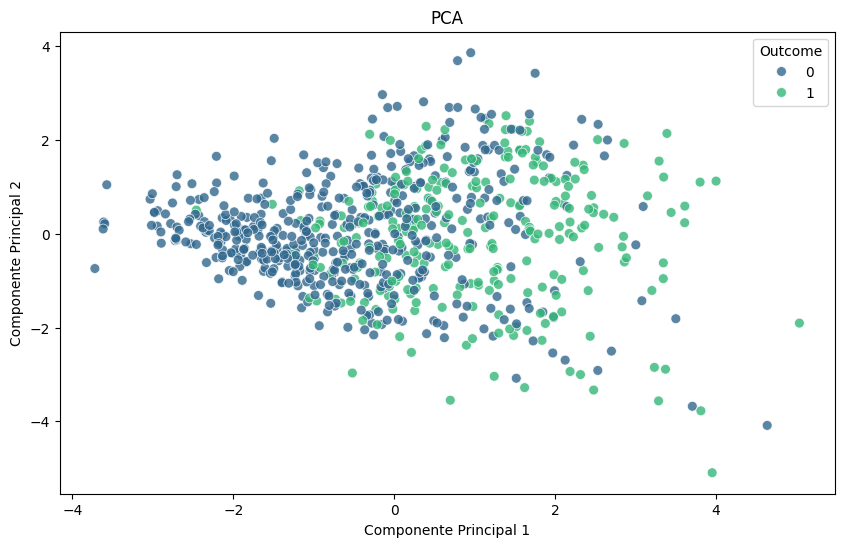

In [ ]:
# Aplicar PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Gaficar PCA con 2 componentes
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='viridis', s=50, alpha=0.8)
plt.title("PCA")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.show()





## Graficar Varianza acumulada vs N° de componente

Esta ayudara a saber que número de componentes en el caso de PCA puede ser utilizado antes de T-SNE o UMAP.

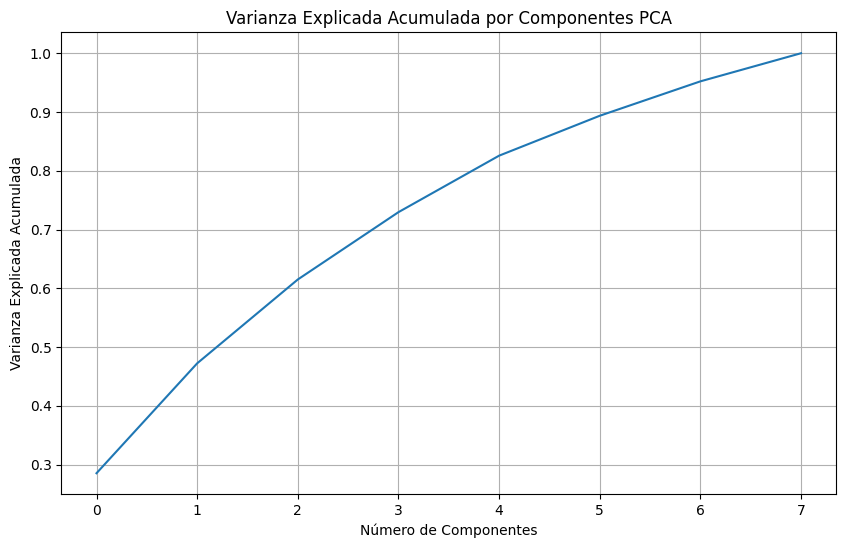

In [ ]:
# Aplicar PCA con todos los componentes
pca_full = PCA()
pca_full.fit(X_scaled)

# Visualizar la varianza explicada por cada componente
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada Acumulada por Componentes PCA')
plt.grid()
plt.show()

Elegí mantener 5 componentes en el PCA que continua, para luego aplicar T-SNE y UMAP, ya que no deberían aplicarse juntos si bajo los componentes a 2 en PCA. Por lo que primero grafiqué y apliqué el modelo pca con dos componentes

## Aplicar los Modelos

En este caso dejamos 5 componentes en PCA para luego utilziar TSNE y UMAP.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


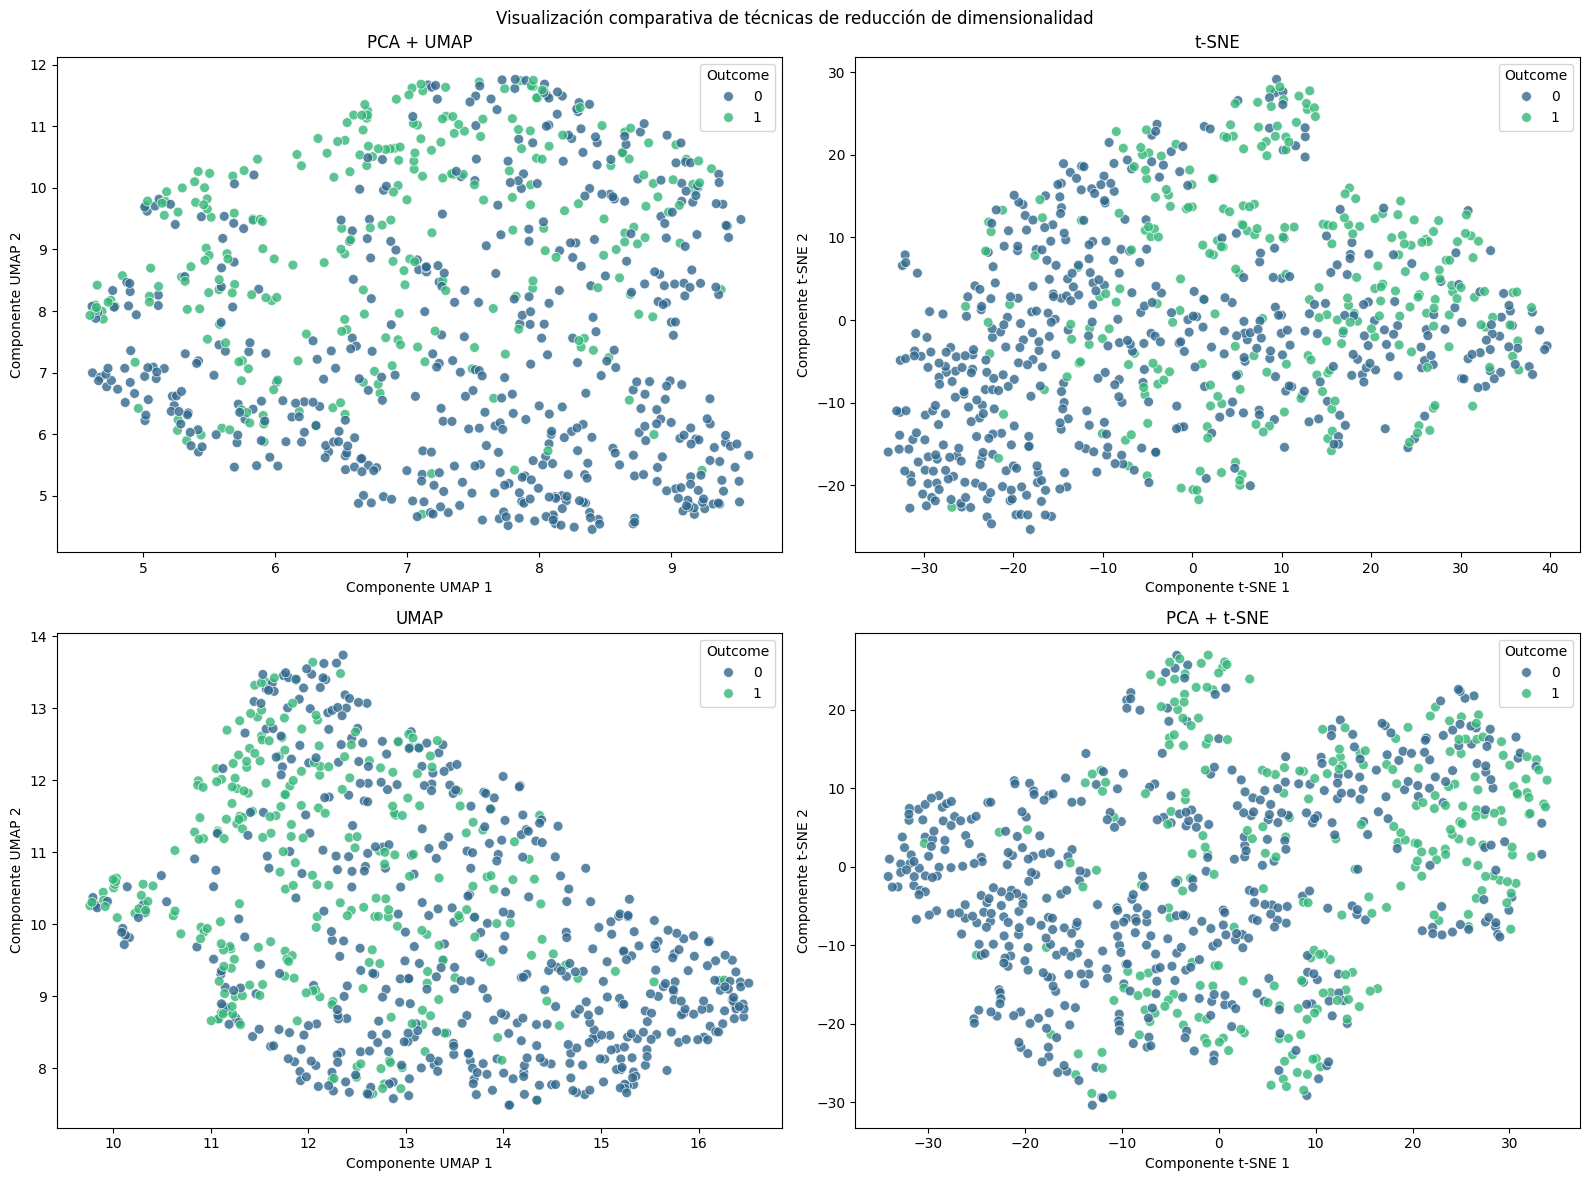

In [ ]:
# Aplicar a PCA dejando 5 componentes
pca_5 = PCA(n_components=5)
X_pca_5 = pca_5.fit_transform(X_scaled)

# Aplicar t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Aplicar UMAP
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=50)
X_umap = reducer.fit_transform(X_scaled)

# Aplicar PCA + t-SNE
# X_pca is already computed in the previous cell
tsne_pca = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne_pca = tsne_pca.fit_transform(X_pca_5)

# Aplicar PCA + UMAP
# X_pca is already computed in the previous cell
reducer_pca = umap.UMAP(n_components=2, random_state=42, n_neighbors=50)
X_umap_pca = reducer_pca.fit_transform(X_pca_5)

# Visualización comparativa
fig, axs = plt.subplots(2, 2, figsize=(16, 12))


# Gráfico t-SNE
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='viridis', ax=axs[0, 1], s=50, alpha=0.8)
axs[0, 1].set_title("t-SNE")
axs[0, 1].set_xlabel('Componente t-SNE 1')
axs[0, 1].set_ylabel('Componente t-SNE 2')

# Gráfico UMAP
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette='viridis', ax=axs[1, 0], s=50, alpha=0.8)
axs[1, 0].set_title("UMAP")
axs[1, 0].set_xlabel('Componente UMAP 1')
axs[1, 0].set_ylabel('Componente UMAP 2')

# Gráfico PCA + t-SNE
sns.scatterplot(x=X_tsne_pca[:, 0], y=X_tsne_pca[:, 1], hue=y, palette='viridis', ax=axs[1, 1], s=50, alpha=0.8)
axs[1, 1].set_title("PCA + t-SNE")
axs[1, 1].set_xlabel('Componente t-SNE 1')
axs[1, 1].set_ylabel('Componente t-SNE 2')

# Gráfico de PCA + UMAP
sns.scatterplot(x=X_umap_pca[:, 0], y=X_umap_pca[:, 1], hue=y, palette='viridis', ax=axs[0, 0], s=50, alpha=0.8)
axs[0, 0].set_title("PCA + UMAP")
axs[0, 0].set_xlabel('Componente UMAP 1')
axs[0, 0].set_ylabel('Componente UMAP 2')


plt.suptitle("Visualización comparativa de técnicas de reducción de dimensionalidad")
plt.tight_layout()
plt.show()

## Prueba de eps para identificar el codo

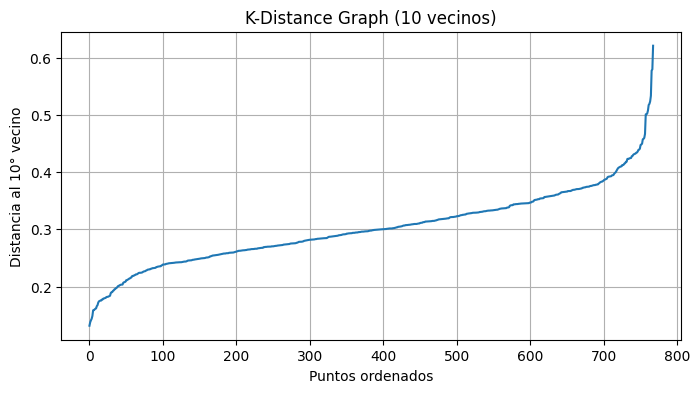

In [ ]:
# KNN para calcular la distancia al k-ésimo vecino
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(X_umap)
distances, indices = neighbors_fit.kneighbors(X_umap)

# Ordenar distancias al décimo vecino
distances = np.sort(distances[:, 9])  # 9 porque n_neighbors=10
plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.title("K-Distance Graph (10 vecinos)")
plt.xlabel("Puntos ordenados")
plt.ylabel("Distancia al 10° vecino")
plt.grid()
plt.show()

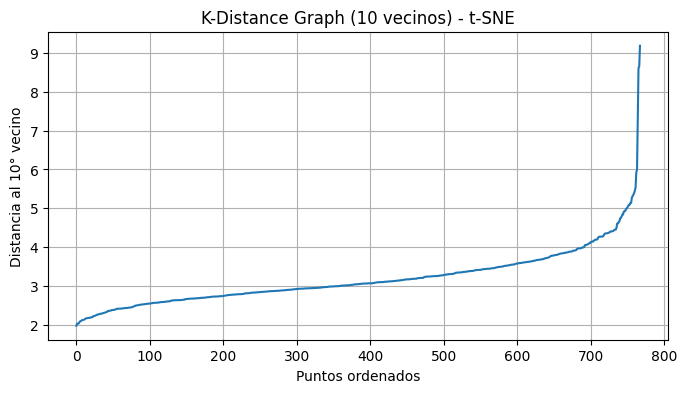

In [ ]:
# KNN para calcular la distancia al k-ésimo vecino
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(X_tsne) # Use X_tsne
distances, indices = neighbors_fit.kneighbors(X_tsne) # Use X_tsne

# Ordenar distancias al décimo vecino
distances = np.sort(distances[:, 9])  # 9 porque n_neighbors=10
plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.title("K-Distance Graph (10 vecinos) - t-SNE")
plt.xlabel("Puntos ordenados")
plt.ylabel("Distancia al 10° vecino")
plt.grid()
plt.show()

In [ ]:
# Ver todas las filas
pd.set_option('display.max_rows', None)

# Ver todas las columnas
pd.set_option('display.max_columns', None)

Con estos dos ejemplos de gráficos de K-vecinos, buscaré eps óptimos entre 0.3 y 0.6

##  Automatización de búsqueda exhaustiva de hiperparámetros y una evaluación para DBSCAN y HDBSCAN

Esté módulo del código realiza lo siguiente:

Itera a través de algoritmos y datasets: Primero ejecuta una serie de modelos DBSCAN y luego una serie de modelos HDBSCAN. Para cada algoritmo, lo aplica a todos los datasets definidos en el diccionario datasets.

Ajusta hiperparámetros:

Para DBSCAN, el código prueba varias combinaciones de los parámetros eps y min_samples para encontrar las configuraciones óptimas.

- eps [0.3, 0.32, 0.34, 0.36, 0.38, 0.40, 0.42, 0.44, 0.46, 0.48, 0.5]
- min_samples [10, 15, 20, 25, 30, 35, 40, 45, 50]

Para HDBSCAN, ajusta el parámetro min_cluster_size.

- min_cluster_size in [5,7,10, 13, 15,17, 20, 22, 25, 27,30]

Evalúa la calidad del clustering: Después de cada ejecución de clustering, el código calcula dos métricas de validación internas comunes:

Puntuación Silhouette: Mide cuán similar es un punto de datos a su propio cluster en comparación con otros. Valores más altos (cercanos a 1) indican clusters mejor definidos.

Índice Davies-Bouldin: Mide la similitud promedio entre clusters. Valores más bajos (cercanos a 0) indican un mejor clustering.

Maneja casos especiales: El código incluye bloques try-except para gestionar situaciones en las que una ejecución de clustering no produce clusters válidos (por ejemplo, si todos los puntos de datos son clasificados como ruido o si un cluster tiene una sola muestra), en cuyo caso las métricas no se calculan.

Recopila los resultados: Todos los resultados, incluyendo el método utilizado, el dataset, los parámetros, el número de clusters encontrados y las puntuaciones de evaluación, se almacenan en una lista de diccionarios.

Genera un informe final: Finalmente, la lista de resultados se convierte en un DataFrame de pandas. Las filas con valores NaN (donde no se pudieron calcular las puntuaciones) se eliminan, y el DataFrame se muestra, proporcionando una tabla clara y estructurada que permite comparar el rendimiento de las diferentes combinaciones de algoritmos y parámetros en cada dataset.

In [ ]:
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import DBSCAN
import hdbscan

# Diccionario de datasets
datasets = {
    "PCA": X_pca,
    "t-SNE": X_tsne,
    "UMAP": X_umap,
    "PCA + t-SNE": X_tsne_pca,
    "PCA + UMAP": X_umap_pca
}

# Lista para almacenar resultados
results = []

# DBSCAN
for name, data in datasets.items():
    for eps in [0.3, 0.32, 0.34, 0.36, 0.38, 0.40, 0.42, 0.44, 0.46, 0.48, 0.5]:
        # Agregar un bucle para min_samples
        for min_samples in [10, 15, 20, 25, 30, 35, 40, 45, 50]: #Rango ajustado para un conjunto de datos de más de 700 filas
            db = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
            labels = db.labels_
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

            if n_clusters > 1:
                valid_labels = labels != -1
                try:
                    dbi = davies_bouldin_score(data[valid_labels], labels[valid_labels])
                    sil = silhouette_score(data[valid_labels], labels[valid_labels])
                    results.append({
                        "Método": "DBSCAN",
                        "Dataset": name,
                        "Parámetro": f"eps={eps:.2f}, min_samples={min_samples}",
                        "Clusters": n_clusters,
                        "Davies-Bouldin": round(dbi, 3),
                        "Silhouette": round(sil, 3)
                    })
                except ValueError:
                   # Manejar casos donde un clúster tiene solo una muestra después de eliminar el ruido
                    results.append({
                        "Método": "DBSCAN",
                        "Dataset": name,
                        "Parámetro": f"eps={eps:.2f}, min_samples={min_samples}",
                        "Clusters": n_clusters,
                        "Davies-Bouldin": None,
                        "Silhouette": None
                    })

            else:
                results.append({
                    "Método": "DBSCAN",
                    "Dataset": name,
                    "Parámetro": f"eps={eps:.2f}, min_samples={min_samples}",
                    "Clusters": n_clusters,
                    "Davies-Bouldin": None,
                    "Silhouette": None
                })


# HDBSCAN
for name, data in datasets.items():
    for min_cluster_size in [5,7,10, 13, 15,17, 20, 22, 25, 27,30]:
        clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size).fit(data)
        labels = clusterer.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        if n_clusters > 1:
            valid_labels = labels != -1
            try:
                dbi = davies_bouldin_score(data[valid_labels], labels[valid_labels])
                sil = silhouette_score(data[valid_labels], labels[valid_labels])
                results.append({
                    "Método": "HDBSCAN",
                    "Dataset": name,
                    "Parámetro": f"min_cluster_size={min_cluster_size}",
                    "Clusters": n_clusters,
                    "Davies-Bouldin": round(dbi, 3),
                    "Silhouette": round(sil, 3)
                })
            except ValueError:
                 results.append({
                    "Método": "HDBSCAN",
                    "Dataset": name,
                    "Parámetro": f"min_cluster_size={min_cluster_size}",
                    "Clusters": n_clusters,
                    "Davies-Bouldin": None,
                    "Silhouette": None
                })

        else:
            results.append({
                "Método": "HDBSCAN",
                "Dataset": name,
                "Parámetro": f"min_cluster_size={min_cluster_size}",
                "Clusters": n_clusters,
                "Davies-Bouldin": None,
                "Silhouette": None
            })


# Convertir a DataFrame
df_resultados = pd.DataFrame(results)

# Mostrar tabla ordenada
df_resultados = df_resultados[["Método", "Dataset", "Parámetro", "Clusters", "Davies-Bouldin", "Silhouette"]]

# eliminar de df_resultados las filas con valores Nan
df_resultados = df_resultados.dropna()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

In [ ]:
# df con resultados de las distintas combinaciones
df_resultados

Método      Dataset                 Parámetro  Clusters  Davies-Bouldin  \
0     DBSCAN          PCA  eps=0.30, min_samples=10         6           0.934   
2     DBSCAN          PCA  eps=0.30, min_samples=20         5           0.677   
9     DBSCAN          PCA  eps=0.32, min_samples=10         5           0.735   
10    DBSCAN          PCA  eps=0.32, min_samples=15         2           0.454   
11    DBSCAN          PCA  eps=0.32, min_samples=20         2           0.916   
13    DBSCAN          PCA  eps=0.32, min_samples=30         2           0.720   
18    DBSCAN          PCA  eps=0.34, min_samples=10         3           0.617   
19    DBSCAN          PCA  eps=0.34, min_samples=15         2           0.518   
21    DBSCAN          PCA  eps=0.34, min_samples=25         4           0.818   
27    DBSCAN          PCA  eps=0.36, min_samples=10         2           0.656   
28    DBSCAN          PCA  eps=0.36, min_samples=15         2           0.788   
31    DBSCAN          PCA  eps=0.36, min_samples=30         2           0.561   
33    DBSCAN          PCA  eps=0.36, min_samples=40         2           0.723   
36    DBSCAN          PCA  eps=0.38, min_samples=10         2           0.671   
37    DBSCAN          PCA  eps=0.38, min_samples=15         2           0.704   
40    DBSCAN          PCA  eps=0.38, min_samples=30         3           0.656   
46    DBSCAN          PCA  eps=0.40, min_samples=15         2           0.831   
47    DBSCAN          PCA  eps=0.40, min_samples=20         2           0.505   
50    DBSCAN          PCA  eps=0.40, min_samples=35         3           0.770   
55    DBSCAN          PCA  eps=0.42, min_samples=15         4           0.725   
56    DBSCAN          PCA  eps=0.42, min_samples=20         2           0.786   
57    DBSCAN          PCA  eps=0.42, min_samples=25         2           0.604   
59    DBSCAN          PCA  eps=0.42, min_samples=35         2           0.829   
64    DBSCAN          PCA  eps=0.44, min_samples=15         3           0.883   
69    DBSCAN          PCA  eps=0.44, min_samples=40         2           0.722   
75    DBSCAN          PCA  eps=0.46, min_samples=25         2           0.526   
79    DBSCAN          PCA  eps=0.46, min_samples=45         2           0.532   
83    DBSCAN          PCA  eps=0.48, min_samples=20         2           0.832   
84    DBSCAN          PCA  eps=0.48, min_samples=25         2           0.545   
92    DBSCAN          PCA  eps=0.50, min_samples=20         2           0.677   
94    DBSCAN          PCA  eps=0.50, min_samples=30         2           0.529   
98    DBSCAN          PCA  eps=0.50, min_samples=50         2           0.809   
198   DBSCAN         UMAP  eps=0.30, min_samples=10        11           0.744   
199   DBSCAN         UMAP  eps=0.30, min_samples=15        10           0.389   
200   DBSCAN         UMAP  eps=0.30, min_samples=20         4           0.175   
207   DBSCAN         UMAP  eps=0.32, min_samples=10         9           2.097   
208   DBSCAN         UMAP  eps=0.32, min_samples=15        13           0.566   
209   DBSCAN         UMAP  eps=0.32, min_samples=20         5           0.240   
216   DBSCAN         UMAP  eps=0.34, min_samples=10         2           0.778   
217   DBSCAN         UMAP  eps=0.34, min_samples=15        13           0.922   
218   DBSCAN         UMAP  eps=0.34, min_samples=20         5           0.326   
226   DBSCAN         UMAP  eps=0.36, min_samples=15         9           0.987   
227   DBSCAN         UMAP  eps=0.36, min_samples=20         8           0.512   
235   DBSCAN         UMAP  eps=0.38, min_samples=15         8           1.153   
236   DBSCAN         UMAP  eps=0.38, min_samples=20         8           0.515   
237   DBSCAN         UMAP  eps=0.38, min_samples=25         4           0.392   
244   DBSCAN         UMAP  eps=0.40, min_samples=15         7           1.216   
245   DBSCAN         UMAP  eps=0.40, min_samples=20         7           0.693   
246   DBSCAN         UMAP  eps=0.40, 

## Aplicación de Filtro

plico un filtro en relación a la cantidad de CLusters, como el dataset original se relaciona a diabetes en clases 0 y 1, buscaremos cluster entre 2 y 5. Ya que podría utilizarse para aplicar más rangos.

In [ ]:
# filtra df_resultados por Clusters valores entre 2 y 5
df_resultados = df_resultados[(df_resultados['Clusters'] >= 2) & (df_resultados['Clusters'] <= 5)]

In [ ]:
# Filtros probados pero que ya no se neceitan ejecutar.

# filtrar df_resultados con Silhouette valor intermedio (0.4–0.6)
#df_resultados = df_resultados[(df_resultados['Silhouette'] >= 0.4)]

# filtrar df_resultados con Davies-Bouldin	 valor intermedio menor a 0.7
#df_resultados = df_resultados[df_resultados['Davies-Bouldin'] <= 0.7]

In [ ]:
df_resultados

Método      Dataset                 Parámetro  Clusters  Davies-Bouldin  \
2     DBSCAN          PCA  eps=0.30, min_samples=20         5           0.677   
9     DBSCAN          PCA  eps=0.32, min_samples=10         5           0.735   
10    DBSCAN          PCA  eps=0.32, min_samples=15         2           0.454   
11    DBSCAN          PCA  eps=0.32, min_samples=20         2           0.916   
13    DBSCAN          PCA  eps=0.32, min_samples=30         2           0.720   
18    DBSCAN          PCA  eps=0.34, min_samples=10         3           0.617   
19    DBSCAN          PCA  eps=0.34, min_samples=15         2           0.518   
21    DBSCAN          PCA  eps=0.34, min_samples=25         4           0.818   
27    DBSCAN          PCA  eps=0.36, min_samples=10         2           0.656   
28    DBSCAN          PCA  eps=0.36, min_samples=15         2           0.788   
31    DBSCAN          PCA  eps=0.36, min_samples=30         2           0.561   
33    DBSCAN          PCA  eps=0.36, min_samples=40         2           0.723   
36    DBSCAN          PCA  eps=0.38, min_samples=10         2           0.671   
37    DBSCAN          PCA  eps=0.38, min_samples=15         2           0.704   
40    DBSCAN          PCA  eps=0.38, min_samples=30         3           0.656   
46    DBSCAN          PCA  eps=0.40, min_samples=15         2           0.831   
47    DBSCAN          PCA  eps=0.40, min_samples=20         2           0.505   
50    DBSCAN          PCA  eps=0.40, min_samples=35         3           0.770   
55    DBSCAN          PCA  eps=0.42, min_samples=15         4           0.725   
56    DBSCAN          PCA  eps=0.42, min_samples=20         2           0.786   
57    DBSCAN          PCA  eps=0.42, min_samples=25         2           0.604   
59    DBSCAN          PCA  eps=0.42, min_samples=35         2           0.829   
64    DBSCAN          PCA  eps=0.44, min_samples=15         3           0.883   
69    DBSCAN          PCA  eps=0.44, min_samples=40         2           0.722   
75    DBSCAN          PCA  eps=0.46, min_samples=25         2           0.526   
79    DBSCAN          PCA  eps=0.46, min_samples=45         2           0.532   
83    DBSCAN          PCA  eps=0.48, min_samples=20         2           0.832   
84    DBSCAN          PCA  eps=0.48, min_samples=25         2           0.545   
92    DBSCAN          PCA  eps=0.50, min_samples=20         2           0.677   
94    DBSCAN          PCA  eps=0.50, min_samples=30         2           0.529   
98    DBSCAN          PCA  eps=0.50, min_samples=50         2           0.809   
200   DBSCAN         UMAP  eps=0.30, min_samples=20         4           0.175   
209   DBSCAN         UMAP  eps=0.32, min_samples=20         5           0.240   
216   DBSCAN         UMAP  eps=0.34, min_samples=10         2           0.778   
218   DBSCAN         UMAP  eps=0.34, min_samples=20         5           0.326   
237   DBSCAN         UMAP  eps=0.38, min_samples=25         4           0.392   
246   DBSCAN         UMAP  eps=0.40, min_samples=25         5           0.355   
253   DBSCAN         UMAP  eps=0.42, min_samples=15         3           0.726   
256   DBSCAN         UMAP  eps=0.42, min_samples=30         2           0.477   
265   DBSCAN         UMAP  eps=0.44, min_samples=30         5           0.366   
272   DBSCAN         UMAP  eps=0.46, min_samples=20         5           0.843   
273   DBSCAN         UMAP  eps=0.46, min_samples=25         5           0.508   
275   DBSCAN         UMAP  eps=0.46, min_samples=35         2           0.519   
281   DBSCAN         UMAP  eps=0.48, min_samples=20         2           0.776   
284   DBSCAN         UMAP  eps=0.48, min_samples=35         4           0.368   
290   DBSCAN         UMAP  eps=0.50, min_samples=20         2           0.777   
293   DBSCAN         UMAP  eps=0.50, min_samples=35         4           0.457   
398   DBSCAN   PCA + UMAP  eps=0.30, min_samples=20         2           0.381   
407   DBSCAN   PCA + UMAP  eps=0.32, 

## Graficar los datos obtenidos para las diversas combinaciones

Estos graficos ofrecen una apreciación visual de cuan cercanos estan los clusters y cuantos son , si hay muchos o pocos outliers (-1), además por cada gráfico se obtiene el valor de Davies-Bouldin y Silhouette que pueden orientar a una elección óptima.

Visualizing all 106 clustering results in a grid:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

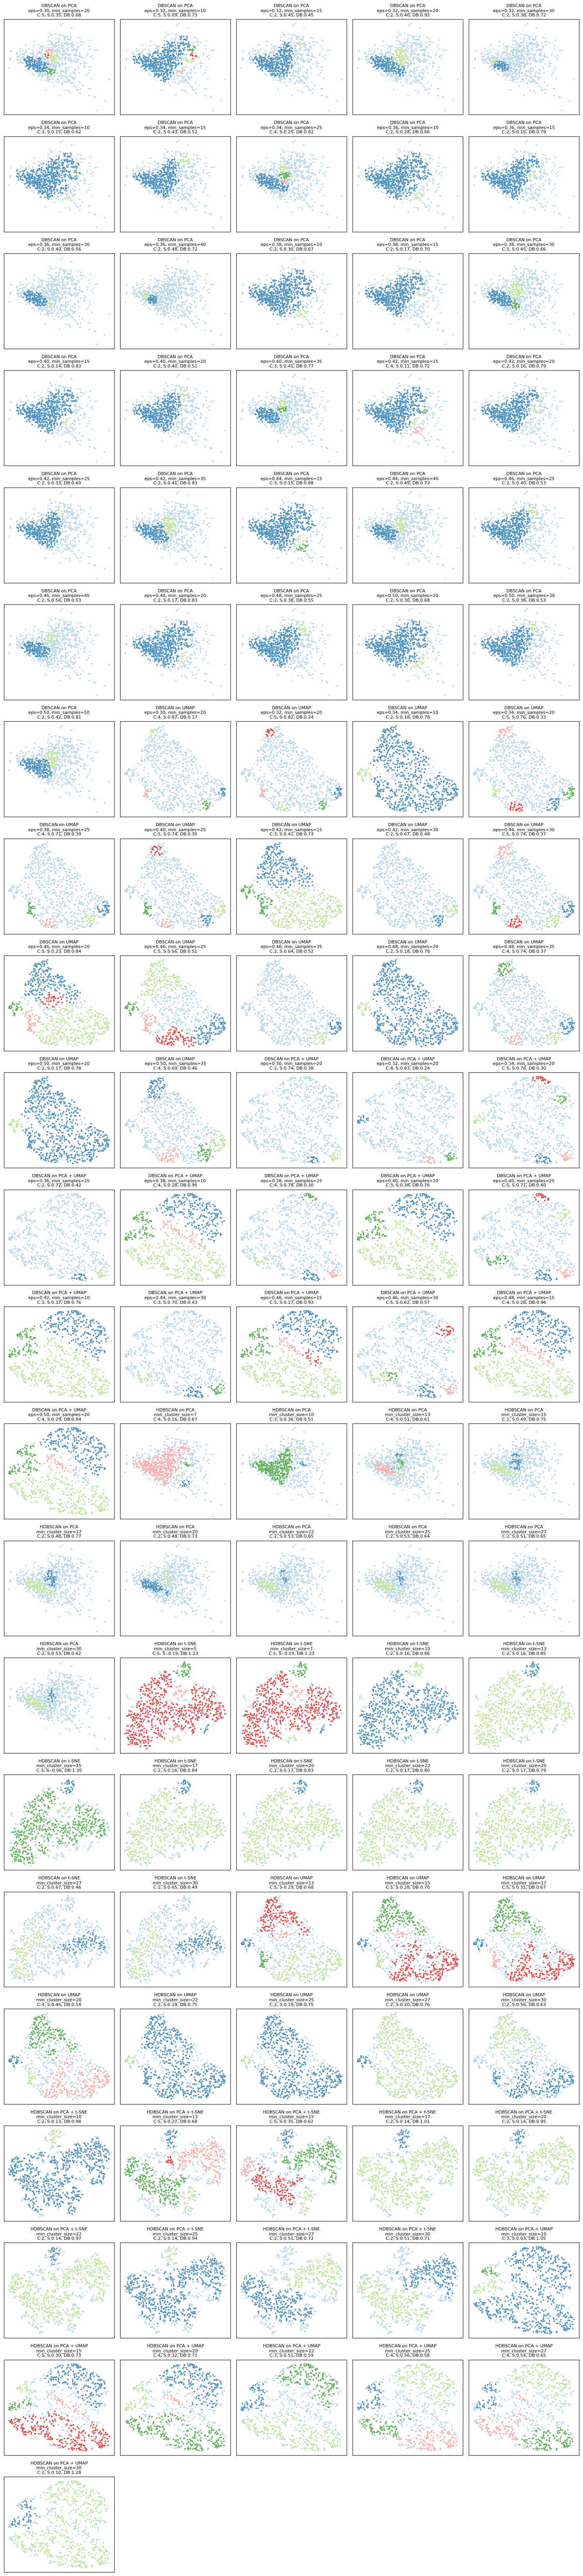

In [ ]:
# Obtener todas las filas de df_resultados
all_results_to_plot = df_resultados.copy()

print(f"Visualizing all {len(all_results_to_plot)} clustering results in a grid:")
# display(all_results_to_plot) # Opcional: mostrar la tabla nuevamente si es necesario

n_plots = len(all_results_to_plot)
if n_plots == 0:
    print("No results to plot in df_resultados.")
else:
    #Determina el tamaño del grid
    n_cols = 5
    n_rows = (n_plots + n_cols - 1) // n_cols

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
    axs = axs.flatten()

    # Esconde los plots no usados
    for j in range(n_plots, len(axs)):
        axs[j].set_visible(False)

    # Usa un contador separado para indexar el array axs
    plot_index = 0
    for i, row in all_results_to_plot.iterrows():
        method = row['Método']
        dataset_name = row['Dataset']
        parameter = row['Parámetro']
        n_clusters = row['Clusters']
        sil = row['Silhouette']
        dbi = row['Davies-Bouldin']
        data = datasets[dataset_name]

        ax = axs[plot_index]

        if method == 'DBSCAN':
            try:
                params_dict = dict(item.split('=') for item in parameter.split(', '))
                eps = float(params_dict['eps'])
                min_samples = int(params_dict['min_samples'])
                model = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
                labels = model.labels_
                title = f'DBSCAN on {dataset_name}\n{parameter}\nC:{n_clusters}, S:{sil:.2f}, DB:{dbi:.2f}'
            except Exception as e:
                labels = None
                title = f"Error in DBSCAN: {e}"
        elif method == 'HDBSCAN':
            try:
                min_cluster_size = int(parameter.split('=')[1])
                model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size).fit(data)
                labels = model.labels_
                title = f'HDBSCAN on {dataset_name}\n{parameter}\nC:{n_clusters}, S:{sil:.2f}, DB:{dbi:.2f}'
            except Exception as e:
                labels = None
                title = f"Error in HDBSCAN: {e}"
        else:
            labels = None
            title = "Unknown Method"

        if labels is not None:
            sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=labels, palette='Paired', ax=ax, s=10, alpha=0.8, legend=False) # Smaller points and no legend for grid
            ax.set_title(title, fontsize=8)
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_xticks([]) # Remueve ticks
            ax.set_yticks([])

        else:
            ax.set_title(title, fontsize=8)
            ax.set_xticks([])
            ax.set_yticks([])

        plot_index += 1 # Incremento en el index plot

    plt.tight_layout()
    plt.show()

## Elección empírica de los modelos a aplicar
La imagen permite un análisis visual de cómo cada técnica de reducción de dimensionalidad afecta la estructura de los datos, por ejemplo cómo se agrupan los puntos y cómo los diferentes parámetros de clustering influyen en el resultado final (número de clusters, tamaño de los clusters, cantidad de ruido).

Algunas combinaciones producen clusters grandes y bien definidos, mientras que otras resultan en una gran cantidad de ruido o en muchos clusters pequeños.

Con esto presente se seleccionaron Dos Modelos con sus respectivos parámetros:

- DBSCAN con X_umap (eps=0.3, min_samples=20)
- HDBSCAN (min_cluster_size=10)

## Modelo DBSCAN y HDBSCAN con X_umap

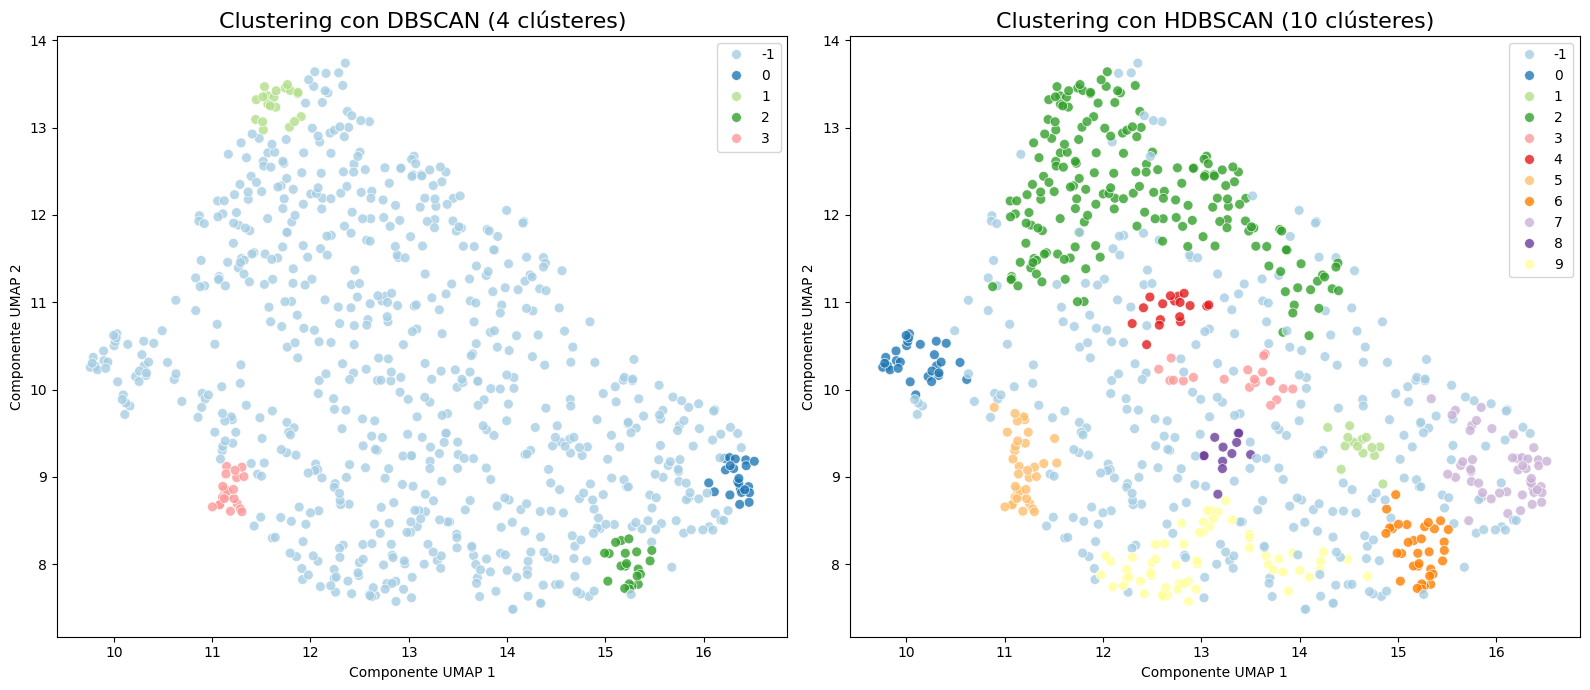

DBSCAN: Coeficiente de Silueta = 0.874, Índice de Davies-Bouldin = 0.175
HDBSCAN: Coeficiente de Silueta = 0.368, Índice de Davies-Bouldin = 0.655


In [ ]:
# Aplicar DBSCAN
# El valor de eps se elige de forma empírica para este ejercicio
dbscan = DBSCAN(eps=0.3, min_samples=20)
dbscan_labels = dbscan.fit_predict(X_umap)

# Aplicar HDBSCAN
hdbscan_model = HDBSCAN(min_cluster_size=10)
hdbscan_labels = hdbscan_model.fit_predict(X_umap)

# Visualización comparativa
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Gráfico DBSCAN
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=dbscan_labels, palette='Paired', ax=ax1, s=50, alpha=0.8)
ax1.set_title(f'Clustering con DBSCAN ({len(set(dbscan_labels)) - 1} clústeres)', fontsize=16)
ax1.set_xlabel('Componente UMAP 1')
ax1.set_ylabel('Componente UMAP 2')

# Gráfico HDBSCAN
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=hdbscan_labels, palette='Paired', ax=ax2, s=50, alpha=0.8)
ax2.set_title(f'Clustering con HDBSCAN ({hdbscan_labels.max() + 1} clústeres)', fontsize=16)
ax2.set_xlabel('Componente UMAP 1')
ax2.set_ylabel('Componente UMAP 2')

plt.tight_layout()
plt.show()

# Evaluación de calidad de los clústeres
# Ignoramos el ruido (etiqueta -1) para el cálculo de métricas
mask_dbscan = dbscan_labels != -1
if len(set(dbscan_labels[mask_dbscan])) > 1:
    sil_dbscan = silhouette_score(X_umap[mask_dbscan], dbscan_labels[mask_dbscan])
    db_dbscan = davies_bouldin_score(X_umap[mask_dbscan], dbscan_labels[mask_dbscan])
    print(f"DBSCAN: Coeficiente de Silueta = {sil_dbscan:.3f}, Índice de Davies-Bouldin = {db_dbscan:.3f}")
else:
    print("DBSCAN: solo un clúster detectado (excluyendo ruido).")


mask_hdbscan = hdbscan_labels != -1
if len(set(hdbscan_labels[mask_hdbscan])) > 1:
    sil_hdbscan = silhouette_score(X_umap[mask_hdbscan], hdbscan_labels[mask_hdbscan])
    db_hdbscan = davies_bouldin_score(X_umap[mask_hdbscan], hdbscan_labels[mask_hdbscan])
    print(f"HDBSCAN: Coeficiente de Silueta = {sil_hdbscan:.3f}, Índice de Davies-Bouldin = {db_hdbscan:.3f}")
else:
    print("HDBSCAN: solo un clúster detectado (excluyendo ruido).")

Los modelos elegidos presentan los mejores parámetros para Coeficiente de Silueta (cercano a 1) y para el Índice de Davies-Bouldin (cercano a 0)

## Contaminación y Outliers

In [ ]:
from sklearn.ensemble import IsolationForest

for cont in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10]:
    iso = IsolationForest(contamination=cont, random_state=42)
    preds = iso.fit_predict(X_scaled)
    n_outliers = np.sum(preds == -1)
    print(f"contamination={cont:.2f} → {n_outliers} outliers detectados")

contamination=0.01 → 8 outliers detectados
contamination=0.02 → 16 outliers detectados
contamination=0.03 → 24 outliers detectados
contamination=0.04 → 31 outliers detectados
contamination=0.05 → 39 outliers detectados
contamination=0.06 → 47 outliers detectados
contamination=0.07 → 54 outliers detectados
contamination=0.08 → 62 outliers detectados
contamination=0.09 → 70 outliers detectados
contamination=0.10 → 77 outliers detectados


## Isolation Forest y One-Class SVM para Modelo DBSCAN y HDBSCAN con X_umap

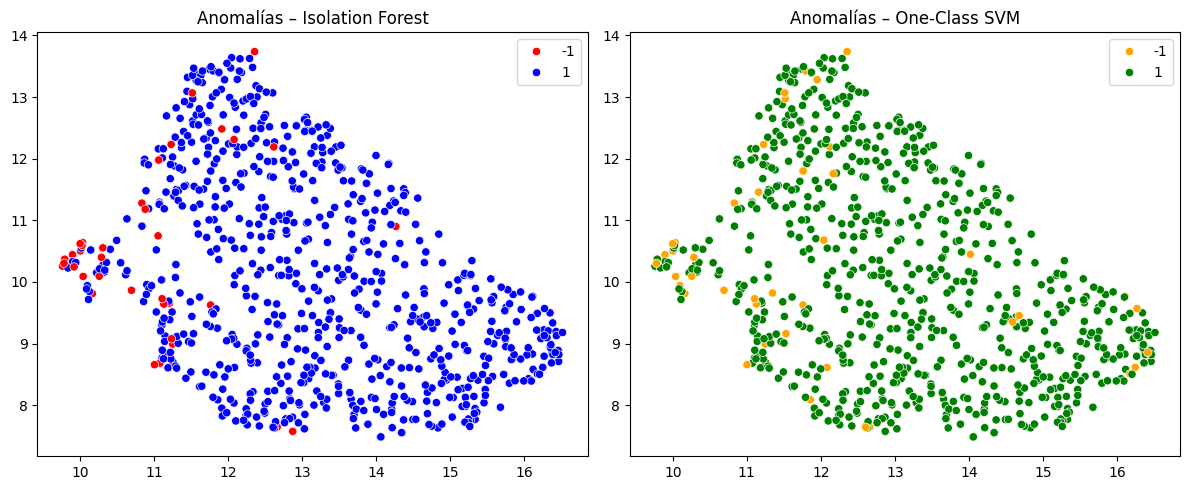

Pacientes anómalos por Isolation Forest: [  4   8  13  18  43  45  57 120 125 159 177 186 220 228 231 247 254 258
 286 362 370 375 409 445 458 487 519 537 579 584 655 661 662 672 673 695
 715 753 763]
Pacientes anómalos por One-Class SVM: [  4   8  13  43  50  57  58  80 106 125 177 186 193 220 228 229 245 247
 258 273 294 303 319 370 375 440 445 455 459 464 466 519 537 575 579 593
 595 597 621 639 661 695 707 715 753]


In [ ]:
# Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
anom_if = iso_forest.fit_predict(X_scaled)  # -1 = outlier, 1 = normal

# One-Class SVM
oc_svm = OneClassSVM(nu=0.05, kernel='rbf', gamma='scale')
anom_svm = oc_svm.fit_predict(X_scaled)  # -1 = outlier, 1 = normal

# Visualización
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=anom_if, palette={1: 'blue', -1: 'red'}, ax=axs[0])
axs[0].set_title("Anomalías – Isolation Forest")

sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=anom_svm, palette={1: 'green', -1: 'orange'}, ax=axs[1])
axs[1].set_title("Anomalías – One-Class SVM")

plt.tight_layout()
plt.show()

# Mostrar IDs de pacientes atípicos
outliers_if = np.where(anom_if == -1)[0]
outliers_svm = np.where(anom_svm == -1)[0]

print("Pacientes anómalos por Isolation Forest:", outliers_if)
print("Pacientes anómalos por One-Class SVM:", outliers_svm)


In [ ]:
# Obtener las filas del marco de datos original correspondientes a los valores atípicos comunes
outliers_if_df = df.iloc[list(outliers_if)]

# Mostrar el marco de datos con filas de valores atípicos de Isolation Forest
print("Outliers detectados por Isolation Forest:")
display(outliers_if_df)

# Obtener las filas del marco de datos original correspondientes a los valores atípicos de SVM de una clase
outliers_svm_df = df.iloc[list(outliers_svm)]

# Mostrar el marco de datos con filas de valores atípicos de SVM de una clase
print("\nOutliers detectados por One-Class SVM:")
display(outliers_svm_df)

Outliers detectados por Isolation Forest:


Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
4              0    137.0           40.0           35.0    168.0  43.1   
8              2    197.0           70.0           45.0    543.0  30.5   
13             1    189.0           60.0           23.0    846.0  30.1   
18             1    103.0           30.0           38.0     83.0  43.3   
43             9    171.0          110.0           24.0    240.0  45.4   
45             0    180.0           66.0           39.0    125.0  42.0   
57             0    100.0           88.0           60.0    110.0  46.8   
120            0    162.0           76.0           56.0    100.0  53.2   
125            1     88.0           30.0           42.0     99.0  55.0   
159           17    163.0           72.0           41.0    114.0  40.9   
177            0    129.0          110.0           46.0    130.0  67.1   
186            8    181.0           68.0           36.0    495.0  30.1   
220            0    177.0           60.0           29.0    478.0  34.6   
228            4    197.0           70.0           39.0    744.0  36.7   
231            6    134.0           80.0           37.0    370.0  46.2   
247            0    165.0           90.0           33.0    680.0  52.3   
254           12     92.0           62.0            7.0    258.0  27.6   
258            1    193.0           50.0           16.0    375.0  25.9   
286            5    155.0           84.0           44.0    545.0  38.7   
362            5    103.0          108.0           37.0    125.0  39.2   
370            3    173.0           82.0           48.0    465.0  38.4   
375           12    140.0           82.0           43.0    325.0  39.2   
409            1    172.0           68.0           49.0    579.0  42.4   
445            0    180.0           78.0           63.0     14.0  59.4   
458           10    148.0           84.0           48.0    237.0  37.6   
487            0    173.0           78.0           32.0    265.0  46.5   
519            6    129.0           90.0            7.0    326.0  19.6   
537            0     57.0           60.0           29.0    125.0  21.7   
579            2    197.0           70.0           99.0    125.0  34.7   
584            8    124.0           76.0           24.0    600.0  28.7   
655            2    155.0           52.0           27.0    540.0  38.7   
661            1    199.0           76.0           43.0    125.0  42.9   
662            8    167.0          106.0           46.0    231.0  37.6   
672           10     68.0          106.0           23.0     49.0  35.5   
673            3    123.0          100.0           35.0    240.0  57.3   
695            7    142.0           90.0           24.0    480.0  30.4   
715            7    187.0           50.0           33.0    392.0  33.9   
753            0    181.0           88.0           44.0    510.0  43.3   
763           10    101.0           76.0           48.0    180.0  32.9   

     DiabetesPedigreeFunction  Age  Outcome  
4                       2.288   33        1  
8                       0.158   53        1  
13                      0.398   59        1  
18                      0.183   33        0  
43                      0.721   54        1  
45                      1.893   25        1  
57                      0.962   31        0  
120                     0.759   25        1  
125                     0.496   26        1  
159                     0.817   47        1  
177                     0.319   26        1  
186                     0.615   60        1  
220                     1.072   21        1  
228                     2.329   31        0  
231                     0.238   46        1  
247                     0.427   23        0  
254                     0.926   44        1  
258                     0.655   24        0  
286                     0.619   34        0  
362                     0.305   65        0  
370                     2.137   25        1  
375                     0.528   


Outliers detectados por One-Class SVM:


Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
4              0    137.0           40.0           35.0    168.0  43.1   
8              2    197.0           70.0           45.0    543.0  30.5   
13             1    189.0           60.0           23.0    846.0  30.1   
43             9    171.0          110.0           24.0    240.0  45.4   
50             1    103.0           80.0           11.0     82.0  19.4   
57             0    100.0           88.0           60.0    110.0  46.8   
58             0    146.0           82.0           29.0    125.0  40.5   
80             3    113.0           44.0           13.0    125.0  22.4   
106            1     96.0          122.0           29.0    125.0  22.4   
125            1     88.0           30.0           42.0     99.0  55.0   
177            0    129.0          110.0           46.0    130.0  67.1   
186            8    181.0           68.0           36.0    495.0  30.1   
193           11    135.0           72.0           29.0    125.0  52.3   
220            0    177.0           60.0           29.0    478.0  34.6   
228            4    197.0           70.0           39.0    744.0  36.7   
229            0    117.0           80.0           31.0     53.0  45.2   
245            9    184.0           85.0           15.0    125.0  30.0   
247            0    165.0           90.0           33.0    680.0  52.3   
258            1    193.0           50.0           16.0    375.0  25.9   
273            1     71.0           78.0           50.0     45.0  33.2   
294            0    161.0           50.0           29.0    125.0  21.9   
303            5    115.0           98.0           29.0    125.0  52.9   
319            6    194.0           78.0           29.0    125.0  23.5   
370            3    173.0           82.0           48.0    465.0  38.4   
375           12    140.0           82.0           43.0    325.0  39.2   
440            0    189.0          104.0           25.0    125.0  34.3   
445            0    180.0           78.0           63.0     14.0  59.4   
455           14    175.0           62.0           30.0    125.0  33.6   
459            9    134.0           74.0           33.0     60.0  25.9   
464           10    115.0           98.0           29.0    125.0  24.0   
466            0     74.0           52.0           10.0     36.0  27.8   
519            6    129.0           90.0            7.0    326.0  19.6   
537            0     57.0           60.0           29.0    125.0  21.7   
575            1    119.0           44.0           47.0     63.0  35.5   
579            2    197.0           70.0           99.0    125.0  34.7   
593            2     82.0           52.0           22.0    115.0  28.5   
595            0    188.0           82.0           14.0    185.0  32.0   
597            1     89.0           24.0           19.0     25.0  27.8   
621            2     92.0           76.0           20.0    125.0  24.2   
639            1    100.0           74.0           12.0     46.0  19.5   
661            1    199.0           76.0           43.0    125.0  42.9   
695            7    142.0           90.0           24.0    480.0  30.4   
707            2    127.0           46.0           21.0    335.0  34.4   
715            7    187.0           50.0           33.0    392.0  33.9   
753            0    181.0           88.0           44.0    510.0  43.3   

     DiabetesPedigreeFunction  Age  Outcome  
4                       2.288   33        1  
8                       0.158   53        1  
13                      0.398   59        1  
43                      0.721   54        1  
50                      0.491   22        0  
57                      0.962   31        0  
58                      1.781   44        0  
80                      0.140   22        0  
106                     0.207   27        0  
125                     0.496   26        1  
177                     0.319   26        1  
186                     0.615   60        1  
19

### Cruce de pacientes anómalos entre Isolation Forest y One-Class SVM en Modelo DBSCAN y HDBSCAN con X_umap

In [ ]:
# Cruza los pacientes anómalos y cuenta cuánto se repiten
common_outliers = set(outliers_if).intersection(set(outliers_svm))

print("\nPacientes anómalos comunes a Isolation Forest y One-Class SVM:", common_outliers)
print("Número de pacientes anómalos comunes:", len(common_outliers))


Pacientes anómalos comunes a Isolation Forest y One-Class SVM: {np.int64(258), np.int64(4), np.int64(519), np.int64(8), np.int64(13), np.int64(661), np.int64(537), np.int64(43), np.int64(177), np.int64(695), np.int64(57), np.int64(186), np.int64(445), np.int64(579), np.int64(715), np.int64(247), np.int64(220), np.int64(228), np.int64(753), np.int64(370), np.int64(375), np.int64(125)}
Número de pacientes anómalos comunes: 22


## Dataframe de los casos Anómalos

In [ ]:
# Obtener las filas desde data set de los valores atípicos comunes
outliers_df = df.iloc[list(common_outliers)]

# Display de outliers_df
display(outliers_df)

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
258            1    193.0           50.0           16.0    375.0  25.9   
4              0    137.0           40.0           35.0    168.0  43.1   
519            6    129.0           90.0            7.0    326.0  19.6   
8              2    197.0           70.0           45.0    543.0  30.5   
13             1    189.0           60.0           23.0    846.0  30.1   
661            1    199.0           76.0           43.0    125.0  42.9   
537            0     57.0           60.0           29.0    125.0  21.7   
43             9    171.0          110.0           24.0    240.0  45.4   
177            0    129.0          110.0           46.0    130.0  67.1   
695            7    142.0           90.0           24.0    480.0  30.4   
57             0    100.0           88.0           60.0    110.0  46.8   
186            8    181.0           68.0           36.0    495.0  30.1   
445            0    180.0           78.0           63.0     14.0  59.4   
579            2    197.0           70.0           99.0    125.0  34.7   
715            7    187.0           50.0           33.0    392.0  33.9   
247            0    165.0           90.0           33.0    680.0  52.3   
220            0    177.0           60.0           29.0    478.0  34.6   
228            4    197.0           70.0           39.0    744.0  36.7   
753            0    181.0           88.0           44.0    510.0  43.3   
370            3    173.0           82.0           48.0    465.0  38.4   
375           12    140.0           82.0           43.0    325.0  39.2   
125            1     88.0           30.0           42.0     99.0  55.0   

     DiabetesPedigreeFunction  Age  Outcome  
258                     0.655   24        0  
4                       2.288   33        1  
519                     0.582   60        0  
8                       0.158   53        1  
13                      0.398   59        1  
661                     1.394   22        1  
537                     0.735   67        0  
43                      0.721   54        1  
177                     0.319   26        1  
695                     0.128   43        1  
57                      0.962   31        0  
186                     0.615   60        1  
445                     2.420   25        1  
579                     0.575   62        1  
715                     0.826   34        1  
247                     0.427   23        0  
220                     1.072   21        1  
228                     2.329   31        0  
753                     0.222   26        1  
370                     2.137   25        1  
375                     0.528   58        1  
125                     0.496   26        1

## Isolation Forest y One-Class SVM en Modelo DBSCAN y HDBSCAN con X_pca

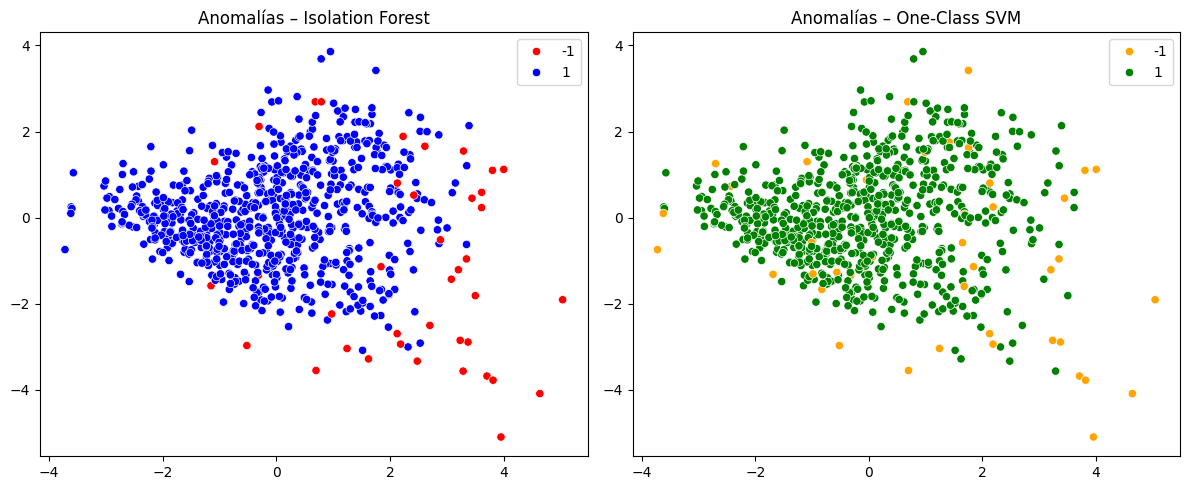

Pacientes anómalos por Isolation Forest: [  4   8  13  18  43  45  57 120 125 159 177 186 220 228 231 247 254 258
 286 362 370 375 409 445 458 487 519 537 579 584 655 661 662 672 673 695
 715 753 763]
Pacientes anómalos por One-Class SVM: [  4   8  13  43  50  57  58  80 106 125 177 186 193 220 228 229 245 247
 258 273 294 303 319 370 375 440 445 455 459 464 466 519 537 575 579 593
 595 597 621 639 661 695 707 715 753]


In [ ]:
# Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
anom_if = iso_forest.fit_predict(X_scaled)  # -1 = outlier, 1 = normal

# One-Class SVM
oc_svm = OneClassSVM(nu=0.05, kernel='rbf', gamma='scale')
anom_svm = oc_svm.fit_predict(X_scaled)  # -1 = outlier, 1 = normal

# Visualización
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=anom_if, palette={1: 'blue', -1: 'red'}, ax=axs[0])
axs[0].set_title("Anomalías – Isolation Forest")

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=anom_svm, palette={1: 'green', -1: 'orange'}, ax=axs[1])
axs[1].set_title("Anomalías – One-Class SVM")

plt.tight_layout()
plt.show()

# Mostrar IDs de pacientes atípicos
outliers_if = np.where(anom_if == -1)[0]
outliers_svm = np.where(anom_svm == -1)[0]

print("Pacientes anómalos por Isolation Forest:", outliers_if)
print("Pacientes anómalos por One-Class SVM:", outliers_svm)


In [ ]:
# Obtener las filas del marco de datos original correspondientes a los valores atípicos comunes
outliers_if_df = df.iloc[list(outliers_if)]

# Mostrar el marco de datos con filas de valores atípicos de Isolation Forest
print("Outliers detectados por Isolation Forest:")
display(outliers_if_df)

# Obtener las filas del marco de datos original correspondientes a los valores atípicos de SVM de una clase
outliers_svm_df = df.iloc[list(outliers_svm)]

# Mostrar el marco de datos con filas de valores atípicos de SVM de una clase
print("\nOutliers detectados por One-Class SVM:")
display(outliers_svm_df)

Outliers detected by Isolation Forest:


Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
4              0    137.0           40.0           35.0    168.0  43.1   
8              2    197.0           70.0           45.0    543.0  30.5   
13             1    189.0           60.0           23.0    846.0  30.1   
18             1    103.0           30.0           38.0     83.0  43.3   
43             9    171.0          110.0           24.0    240.0  45.4   
45             0    180.0           66.0           39.0    125.0  42.0   
57             0    100.0           88.0           60.0    110.0  46.8   
120            0    162.0           76.0           56.0    100.0  53.2   
125            1     88.0           30.0           42.0     99.0  55.0   
159           17    163.0           72.0           41.0    114.0  40.9   
177            0    129.0          110.0           46.0    130.0  67.1   
186            8    181.0           68.0           36.0    495.0  30.1   
220            0    177.0           60.0           29.0    478.0  34.6   
228            4    197.0           70.0           39.0    744.0  36.7   
231            6    134.0           80.0           37.0    370.0  46.2   
247            0    165.0           90.0           33.0    680.0  52.3   
254           12     92.0           62.0            7.0    258.0  27.6   
258            1    193.0           50.0           16.0    375.0  25.9   
286            5    155.0           84.0           44.0    545.0  38.7   
362            5    103.0          108.0           37.0    125.0  39.2   
370            3    173.0           82.0           48.0    465.0  38.4   
375           12    140.0           82.0           43.0    325.0  39.2   
409            1    172.0           68.0           49.0    579.0  42.4   
445            0    180.0           78.0           63.0     14.0  59.4   
458           10    148.0           84.0           48.0    237.0  37.6   
487            0    173.0           78.0           32.0    265.0  46.5   
519            6    129.0           90.0            7.0    326.0  19.6   
537            0     57.0           60.0           29.0    125.0  21.7   
579            2    197.0           70.0           99.0    125.0  34.7   
584            8    124.0           76.0           24.0    600.0  28.7   
655            2    155.0           52.0           27.0    540.0  38.7   
661            1    199.0           76.0           43.0    125.0  42.9   
662            8    167.0          106.0           46.0    231.0  37.6   
672           10     68.0          106.0           23.0     49.0  35.5   
673            3    123.0          100.0           35.0    240.0  57.3   
695            7    142.0           90.0           24.0    480.0  30.4   
715            7    187.0           50.0           33.0    392.0  33.9   
753            0    181.0           88.0           44.0    510.0  43.3   
763           10    101.0           76.0           48.0    180.0  32.9   

     DiabetesPedigreeFunction  Age  Outcome  
4                       2.288   33        1  
8                       0.158   53        1  
13                      0.398   59        1  
18                      0.183   33        0  
43                      0.721   54        1  
45                      1.893   25        1  
57                      0.962   31        0  
120                     0.759   25        1  
125                     0.496   26        1  
159                     0.817   47        1  
177                     0.319   26        1  
186                     0.615   60        1  
220                     1.072   21        1  
228                     2.329   31        0  
231                     0.238   46        1  
247                     0.427   23        0  
254                     0.926   44        1  
258                     0.655   24        0  
286                     0.619   34        0  
362                     0.305   65        0  
370                     2.137   25        1  
375                     0.528   


Outliers detected by One-Class SVM:


Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
4              0    137.0           40.0           35.0    168.0  43.1   
8              2    197.0           70.0           45.0    543.0  30.5   
13             1    189.0           60.0           23.0    846.0  30.1   
43             9    171.0          110.0           24.0    240.0  45.4   
50             1    103.0           80.0           11.0     82.0  19.4   
57             0    100.0           88.0           60.0    110.0  46.8   
58             0    146.0           82.0           29.0    125.0  40.5   
80             3    113.0           44.0           13.0    125.0  22.4   
106            1     96.0          122.0           29.0    125.0  22.4   
125            1     88.0           30.0           42.0     99.0  55.0   
177            0    129.0          110.0           46.0    130.0  67.1   
186            8    181.0           68.0           36.0    495.0  30.1   
193           11    135.0           72.0           29.0    125.0  52.3   
220            0    177.0           60.0           29.0    478.0  34.6   
228            4    197.0           70.0           39.0    744.0  36.7   
229            0    117.0           80.0           31.0     53.0  45.2   
245            9    184.0           85.0           15.0    125.0  30.0   
247            0    165.0           90.0           33.0    680.0  52.3   
258            1    193.0           50.0           16.0    375.0  25.9   
273            1     71.0           78.0           50.0     45.0  33.2   
294            0    161.0           50.0           29.0    125.0  21.9   
303            5    115.0           98.0           29.0    125.0  52.9   
319            6    194.0           78.0           29.0    125.0  23.5   
370            3    173.0           82.0           48.0    465.0  38.4   
375           12    140.0           82.0           43.0    325.0  39.2   
440            0    189.0          104.0           25.0    125.0  34.3   
445            0    180.0           78.0           63.0     14.0  59.4   
455           14    175.0           62.0           30.0    125.0  33.6   
459            9    134.0           74.0           33.0     60.0  25.9   
464           10    115.0           98.0           29.0    125.0  24.0   
466            0     74.0           52.0           10.0     36.0  27.8   
519            6    129.0           90.0            7.0    326.0  19.6   
537            0     57.0           60.0           29.0    125.0  21.7   
575            1    119.0           44.0           47.0     63.0  35.5   
579            2    197.0           70.0           99.0    125.0  34.7   
593            2     82.0           52.0           22.0    115.0  28.5   
595            0    188.0           82.0           14.0    185.0  32.0   
597            1     89.0           24.0           19.0     25.0  27.8   
621            2     92.0           76.0           20.0    125.0  24.2   
639            1    100.0           74.0           12.0     46.0  19.5   
661            1    199.0           76.0           43.0    125.0  42.9   
695            7    142.0           90.0           24.0    480.0  30.4   
707            2    127.0           46.0           21.0    335.0  34.4   
715            7    187.0           50.0           33.0    392.0  33.9   
753            0    181.0           88.0           44.0    510.0  43.3   

     DiabetesPedigreeFunction  Age  Outcome  
4                       2.288   33        1  
8                       0.158   53        1  
13                      0.398   59        1  
43                      0.721   54        1  
50                      0.491   22        0  
57                      0.962   31        0  
58                      1.781   44        0  
80                      0.140   22        0  
106                     0.207   27        0  
125                     0.496   26        1  
177                     0.319   26        1  
186                     0.615   60        1  
19

### Cruce de pacientes anómalos en Modelo DBSCAN y HDBSCAN con X_umap

In [ ]:
# Cruza los pacientes anómalos y cuenta cuánto se repiten
common_outliers = set(outliers_if).intersection(set(outliers_svm))

print("\nPacientes anómalos comunes a Isolation Forest y One-Class SVM:", common_outliers)
print("Número de pacientes anómalos comunes:", len(common_outliers))


Pacientes anómalos comunes a Isolation Forest y One-Class SVM: {np.int64(258), np.int64(4), np.int64(519), np.int64(8), np.int64(13), np.int64(661), np.int64(537), np.int64(43), np.int64(177), np.int64(695), np.int64(57), np.int64(186), np.int64(445), np.int64(579), np.int64(715), np.int64(247), np.int64(220), np.int64(228), np.int64(753), np.int64(370), np.int64(375), np.int64(125)}
Número de pacientes anómalos comunes: 22


In [ ]:
# Obtener las filas desde data set de los valores atípicos comunes
outliers_df = df.iloc[list(common_outliers)]

# Display de outliers_df
display(outliers_df)

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
258            1    193.0           50.0           16.0    375.0  25.9   
4              0    137.0           40.0           35.0    168.0  43.1   
519            6    129.0           90.0            7.0    326.0  19.6   
8              2    197.0           70.0           45.0    543.0  30.5   
13             1    189.0           60.0           23.0    846.0  30.1   
661            1    199.0           76.0           43.0    125.0  42.9   
537            0     57.0           60.0           29.0    125.0  21.7   
43             9    171.0          110.0           24.0    240.0  45.4   
177            0    129.0          110.0           46.0    130.0  67.1   
695            7    142.0           90.0           24.0    480.0  30.4   
57             0    100.0           88.0           60.0    110.0  46.8   
186            8    181.0           68.0           36.0    495.0  30.1   
445            0    180.0           78.0           63.0     14.0  59.4   
579            2    197.0           70.0           99.0    125.0  34.7   
715            7    187.0           50.0           33.0    392.0  33.9   
247            0    165.0           90.0           33.0    680.0  52.3   
220            0    177.0           60.0           29.0    478.0  34.6   
228            4    197.0           70.0           39.0    744.0  36.7   
753            0    181.0           88.0           44.0    510.0  43.3   
370            3    173.0           82.0           48.0    465.0  38.4   
375           12    140.0           82.0           43.0    325.0  39.2   
125            1     88.0           30.0           42.0     99.0  55.0   

     DiabetesPedigreeFunction  Age  Outcome  
258                     0.655   24        0  
4                       2.288   33        1  
519                     0.582   60        0  
8                       0.158   53        1  
13                      0.398   59        1  
661                     1.394   22        1  
537                     0.735   67        0  
43                      0.721   54        1  
177                     0.319   26        1  
695                     0.128   43        1  
57                      0.962   31        0  
186                     0.615   60        1  
445                     2.420   25        1  
579                     0.575   62        1  
715                     0.826   34        1  
247                     0.427   23        0  
220                     1.072   21        1  
228                     2.329   31        0  
753                     0.222   26        1  
370                     2.137   25        1  
375                     0.528   58        1  
125                     0.496   26        1

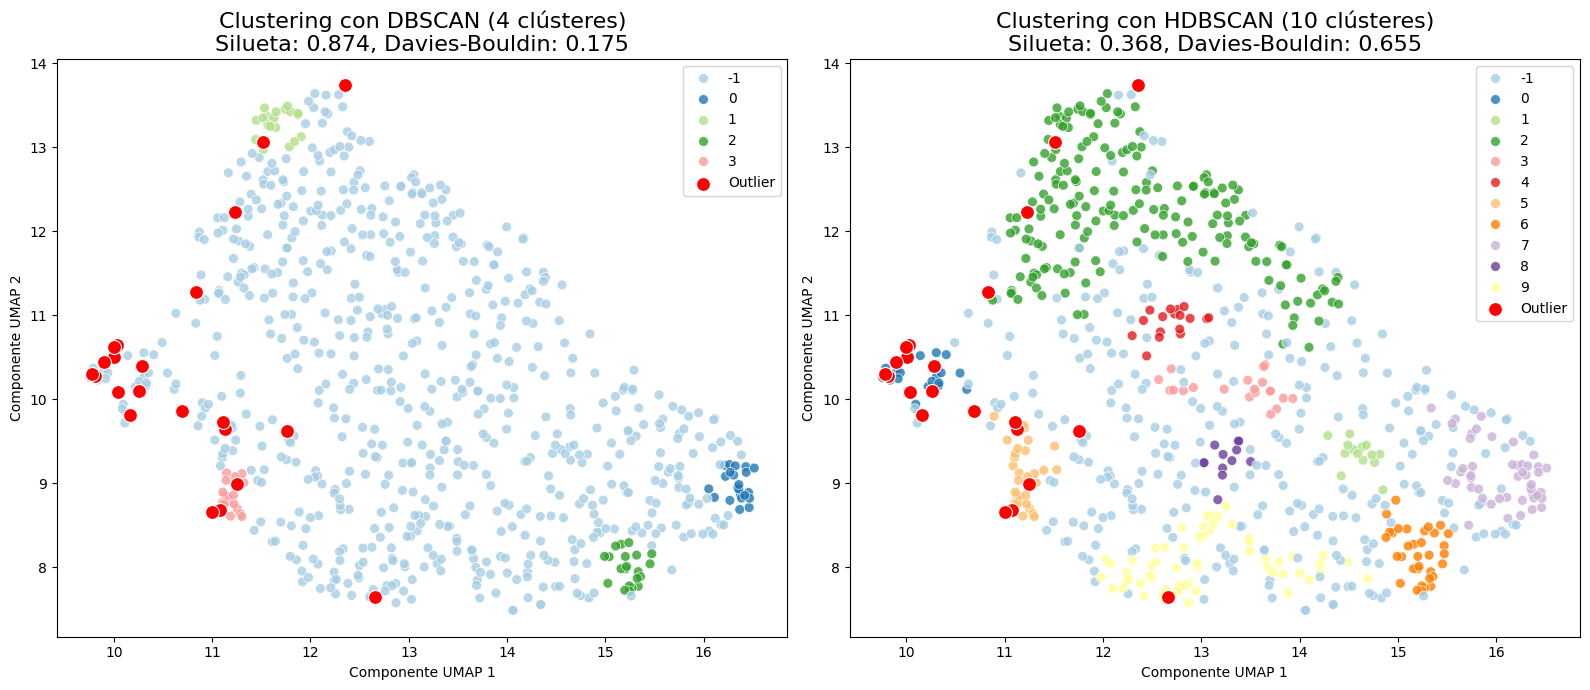

In [ ]:
# Obtener los índices de los valores atípicos comunes
outlier_indices = list(common_outliers)

# Crea una máscara para outliers
is_outlier = np.zeros(X_umap.shape[0], dtype=bool)
is_outlier[outlier_indices] = True

# Visualización comparativa con outliers resaltados
fig, axs = plt.subplots(1, 2, figsize=(16, 7))

# Gráfico DBSCAN
# Plot normal con cluster con colores
sns.scatterplot(x=X_umap[~is_outlier, 0], y=X_umap[~is_outlier, 1], hue=dbscan_labels[~is_outlier], palette='Paired', ax=axs[0], s=50, alpha=0.8, legend='full')

# Plot outliers en rojo
sns.scatterplot(x=X_umap[is_outlier, 0], y=X_umap[is_outlier, 1], color='red', ax=axs[0], s=100, alpha=1.0, label='Outlier')
axs[0].set_title(f'Clustering con DBSCAN ({len(set(dbscan_labels)) - 1} clústeres)\nSilueta: {sil_dbscan:.3f}, Davies-Bouldin: {db_dbscan:.3f}', fontsize=16)
axs[0].set_xlabel('Componente UMAP 1')
axs[0].set_ylabel('Componente UMAP 2')
axs[0].legend()


# Gráfico HDBSCAN
# Plot normal con cluster con colores
sns.scatterplot(x=X_umap[~is_outlier, 0], y=X_umap[~is_outlier, 1], hue=hdbscan_labels[~is_outlier], palette='Paired', ax=axs[1], s=50, alpha=0.8, legend='full')
# Plot outliers en rojo
sns.scatterplot(x=X_umap[is_outlier, 0], y=X_umap[is_outlier, 1], color='red', ax=axs[1], s=100, alpha=1.0, label='Outlier')
axs[1].set_title(f'Clustering con HDBSCAN ({hdbscan_labels.max() + 1} clústeres)\nSilueta: {sil_hdbscan:.3f}, Davies-Bouldin: {db_hdbscan:.3f}', fontsize=16)
axs[1].set_xlabel('Componente UMAP 1')
axs[1].set_ylabel('Componente UMAP 2')
axs[1].legend()


plt.tight_layout()
plt.show()

Con los dos modelos los resultados del cruce fueron los mismo. Por lo que outliers_df entrega 22 casos de pacientes anómalos a investigar.

## Análisis cruzado

###¿Coinciden las anomalías con clústeres raros?

Sí, existe una coincidencia. Las anomalías detectadas por Isolation Forest y One-Class SVM tienden a estar ubicadas en las regiones dispersas de los gráficos UMAP y PCA, a menudo coincidiendo con los puntos de ruido (-1) identificados por DBSCAN. Esto sugiere que estos puntos atípicos no encajan bien en los clústeres principales y podrían ser considerados como parte de "clústeres raros" o aislados.


### ¿Qué técnica dio resultados más interpretables? La interpretabilidad depende del objetivo.
PCA ofrece interpretabilidad a nivel de características originales, pero los clústeres no estaban bien definidos en 2D.

UMAP (y t-SNE) junto con DBSCAN o HDBSCAN en el espacio reducido proporcionaron clústeres visualmente más distintos, lo que facilita la identificación de posibles subgrupos de pacientes.

En general, la combinación de UMAP con DBSCAN o HDBSCAN parece ofrecer resultados más interpretables en términos de identificar agrupaciones de pacientes en el espacio de baja dimensión, especialmente cuando se consideran las métricas de evaluación y las visualizaciones en conjunto.

## Conclusión

En este análisis, se aplicaron técnicas de reducción de dimensionalidad (PCA, t-SNE, UMAP) y algoritmos de clustering basados en densidad (DBSCAN, HDBSCAN) para identificar segmentos de pacientes y detectar anomalías en el dataset de diabetes. Se evaluaron diversas combinaciones de parámetros utilizando métricas como el coeficiente de Silhouette y el índice de Davies-Bouldin, complementando la evaluación con visualizaciones en 2D.

Los resultados sugieren que UMAP, en combinación con DBSCAN o HDBSCAN, permitió visualizar agrupaciones de pacientes de manera más clara en el espacio de baja dimensión en comparación con PCA en 2D. La búsqueda exhaustiva de hiperparámetros reveló que existe un compromiso entre optimizar las métricas de evaluación y obtener clústeres con una estructura interpretable y un número de puntos clínicamente relevante.

La detección de anomalías utilizando Isolation Forest y One-Class SVM identificó un conjunto de pacientes atípicos. Estos outliers tienden a ubicarse en regiones de baja densidad en las visualizaciones de dimensionalidad reducida y, en muchos casos, coinciden con los puntos de ruido identificados por DBSCAN. Esto refuerza la idea de que estos pacientes presentan perfiles de características inusuales en comparación con la mayoría de la población del estudio.

En futuros pasos, sería valioso realizar un análisis más profundo de las características clínicas de los clústeres identificados y de los pacientes anómalos para comprender mejor las posibles implicaciones médicas de estos hallazgos. La validación externa de los clústeres con información clínica adicional (si estuviera disponible) también sería importante para confirmar su relevancia.